In case any of these libraries are missing, run the code below.

In [ ]:
!pip install ipython-autotime
!pip install tqdm
!pip install multiprocess
!pip install numpy
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install scipy

In [1]:
import autotime
from tqdm import tqdm_notebook
from tqdm.auto import tqdm

import numpy as np
import networkx as nx
import csv
from collections import Counter 
from sklearn.cluster import KMeans, AgglomerativeClustering
import random
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
import heapq
from multiprocess import Pool

In [2]:
datasets = ['Oregon-1.txt', 'soc-Epinions1.txt', 'web-NotreDame.txt', 'roadNet-CA.txt']
part1_datasets = ['ca-GrQc.txt', 'ca-HepTh.txt', 'ca-HepPh.txt', 'ca-CondMat.txt', 'ca-AstroPh.txt']
all_datasets = part1_datasets + datasets

### Helper Functions

In [3]:
def read_graph_data(graph_file_name, subsample=None, custom_k=None):
    G_id = None
    edges = []
    with open('data/'+graph_file_name) as G_file:
        G_data_reader = csv.reader(G_file, delimiter=' ')
        header = next(G_data_reader)
        G_id = header[1]
        if custom_k:
            k = custom_k
        else:
            k = int(header[4])
        for row in G_data_reader:
            if subsample is None or random.random() <= subsample:
                edges.append((int(row[0]), int(row[1])))
    return G_id, edges, k

In [4]:
def get_networkx_graph(G_id, edges):
    G = nx.Graph(name=G_id)
    G.add_edges_from(edges)
    return G

In [5]:
def transform_clusters_to_dict(clusters):
    clusters_dict = {}
    for cid, cluster in enumerate(clusters):
        for node in cluster:
            clusters_dict[node] = cid
    return clusters_dict

In [6]:
def get_clusters_as_dict(G, clusters):
    clusters_dict = {}
    for i, u in enumerate(G.nodes()):
        clusters_dict[u] = clusters[i]
    return clusters_dict

In [7]:
def get_degrees(G):
    A = nx.adjacency_matrix(G)
    return A.sum(axis=1)

In [8]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [9]:
def write_results(G_id, G, cluster, k):
    first_row = "# " + str(G_id)+ " " + str(G.number_of_nodes())+ " " + \
        str(G.number_of_edges()) +  " " + str(k) + "\n"
    output = open("results/"+str(G_id)+".output","w+")
    output.write(first_row)
    for key, val in cluster.items():
        row = str(key) + " " + str(val) + "\n"
        output.write(row)
    output.close()

In [10]:
def get_degree(G):
    A = (nx.adjacency_matrix(G,nodelist=range(0,G.number_of_nodes())))
    D = A.sum(axis=1)
    D = np.array(D.reshape((len(D),)))
    D = D[0]
    return scipy.sparse.diags(D)

### Objective function / Metric

In [11]:
def objective_function(G, clusters_dict):   
    min_size = min(Counter(clusters_dict.values()).values())
    E_cuts = 0
    for u, v in G.edges:
        if clusters_dict[u] != clusters_dict[v]:
            E_cuts += 1
    return E_cuts / min_size, E_cuts, min_size

### Balanced K-Means

In [12]:
def kmeans_balanced(X, k):
    # Randomly choose clusters
    rng = np.random.RandomState(42)
    i = rng.permutation(X.shape[0])[:k]
    centers = X[i]
    distances = None
    threshold = int(X.shape[0]/k) + 20
    occupied = set()
    labels = np.empty((X.shape[0],))
    loops = 0
    while True and loops < 50:
        loops += 1
        # Assign labels based on closest center
        for i in range(k):
            dist = np.sqrt(np.sum(np.square(X - centers[i]), axis=1))
            if distances is None:
                distances = dist
            else:
                distances = np.vstack((distances, dist))

        for i, dist_k in enumerate(distances):
            dist_k_s = set(np.argsort(dist_k).flat)
            dist_k_s = list(dist_k_s - occupied)[:threshold]  # for me it doesn't break is `threshold` out of bounds
            labels[dist_k_s] = i
            occupied.update(dist_k_s)
        occupied = set()
        distances = None
        # Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(k)])
        
        # Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    print('KMeans loops:', loops)
    return labels.astype(int)

In [13]:
def kmeans_unbalanced(U,k,G):
    kmeans = KMeans(k)
    labels = kmeans.fit_predict(U)
    clust_dict = {n:c for n,c in zip(range(0,G.number_of_nodes()),labels) }
    return clust_dict

### Balanced Spectral Clustering

In [14]:
def spectral_clustering_balanced(G, k, laplacian_type='normalized'):
    if laplacian_type == 'normalized':
        A = (nx.adjacency_matrix(G,nodelist=range(0,G.number_of_nodes())))
        D = A.sum(axis=1)
        D = np.array(D.reshape((len(D),)))
        D = D[0]
        D = scipy.sparse.diags(np.power(D,-0.5))

        L = scipy.sparse.identity(A.shape[0]) - D @ A @ D # normalized laplacian
        # fast eigendecomposition that returns the k smallest eigenpairs
        _, vec = scipy.sparse.linalg.eigs(scipy.sparse.csr_matrix(L), k=k, which='SR')
        U = vec.real # take the real part
        # normalize U rows
        U = (U.T / np.sqrt(np.sum(np.square(U), axis=1)))
        cluster = kmeans_unbalanced(U.T, k, G)
    elif laplacian_type == 'unnormalized':
        A = (nx.adjacency_matrix(G,nodelist=range(0,G.number_of_nodes())))
        D = A.sum(axis=1)
        D = np.array(D.reshape((len(D),)))
        D = D[0]
        D = scipy.sparse.diags(D)
        L = D - A
        _, vec =  scipy.sparse.linalg.eigs(scipy.sparse.csr_matrix(L), k=k, which='SR')
        U = vec.real
        cluster = kmeans_unbalanced(U,k,G)
    elif laplacian_type == 'shi_malik':
        Us = []
        clusterings = []
        A = (nx.adjacency_matrix(G,nodelist=range(0,G.number_of_nodes())))
        D = A.sum(axis=1)
        D = np.array(D.reshape((len(D),)))
        D = D[0]
        D = scipy.sparse.diags(D)
        L = D - A
        _, vec =  scipy.sparse.linalg.eigs(A=scipy.sparse.csc_matrix(L),M=get_degree(G), k=k, which='SR')
        U = vec.real
        cluster = kmeans_unbalanced(U,k,G)
    return cluster

In [15]:
def edge_betweenness_centrality_subset_parallel(G, sources, targets, processes=None):
    def _betmap(args):
        return nx.edge_betweenness_centrality_subset(*args)
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool)
    src_node_chunks = list(chunks(sources, max(1, int(len(sources) / node_divisor))))
    trg_node_chunks = list(chunks(targets, max(1, int(len(targets) / node_divisor))))
    num_chunks = len(src_node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      src_node_chunks * num_chunks,
                      trg_node_chunks * num_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [16]:
def bridge_cut_clustering(G, k=2, max_iter=None, betweenness_heuristic=False, parallel=False):
    def __bridge_cut_clustering(Gs, k=k, max_iter=max_iter):
        # check if recursion has to end
        if k == len(Gs):
            return Gs  
        # check if connected components exist already
        if len(Gs) == 1:
            G = Gs[0]
            if nx.number_connected_components(G) > 1:
                print('Found some components ;)')
                Gs = list(nx.connected_component_subgraphs(G))
                return __bridge_cut_clustering(Gs, k=k, max_iter=max_iter)
            # else do what you have to do *sigh*  
        # G to split next, the biggest one with good bridges
        bridges = []
        removed = []
        while Gs:
            if len(Gs) > 1:
                G = Gs[np.argmax([nx.number_of_nodes(g) for g in Gs])]
            elif len(Gs) == 1:
                G = Gs[0]
            else:
                break
            bridges_ = list(nx.bridges(G))
            if bridges_ is None or bridges_ == []:
                Gs.remove(G)
                removed.append(G)
                continue
            for bridge in bridges_:
                u, v = bridge
                if G.degree(u) > 1 and G.degree(v) > 1:
                    bridges.append(bridge)
                    
            if bridges == []:
                Gs.remove(G)
                removed.append(G)
            else:
                break
 
        if not Gs:  # no graph has bridges
            print('No graph has useful bridges :(')
            return None
        Gs.extend(removed)
        Gs.remove(G) # we don't need it - it will be cut
        
        # Betweenness heuristic
        ctrl_bridges = set()
        if betweenness_heuristic and len(Gs) == 0:
            src_nodes_subset = np.random.choice(list(G.nodes()), 3000)
            trg_nodes_subset = np.random.choice(list(G.nodes()), 3000)
            btn_centrality = edge_betweenness_centrality_subset_parallel(G, src_nodes_subset, trg_nodes_subset)
            bridges_centrality = {x: btn_centrality[x] for x in list(nx.bridges(G)) if x in btn_centrality}
            ctrl_bridges = set(heapq.nlargest(max(50, k), bridges_centrality, key=bridges_centrality.get))
        if betweenness_heuristic:
            bridges = list(ctrl_bridges.intersection(set(bridges)))
 
        ### actual procedure ###
        ### parallelization
        def __parallel_bridge(args):
            G, bridges, max_iter = args
            best_size = -1
            best_clustering = None
            best_bridge = None
            it = 0
            for bridge in tqdm(bridges):
                u, v = bridge
                G.remove_edge(u, v)
                clusters = list(nx.connected_components(G))
                min_clusters_size = min([len(cluster) for cluster in clusters])
                if best_size < min_clusters_size:
                    best_size = min_clusters_size
                    best_clustering = clusters
                    best_bridge = bridge
                it += 1
                G.add_edge(*bridge)
                if max_iter is not None and it > max_iter:
                    break
            return best_clustering, best_bridge
        ### end
        ##############
        if parallel:
            p = Pool(processes=None)
            bridge_divisor = len(p._pool)
            bridge_chunks = list(chunks(bridges, min(1, int(len(bridges) / bridge_divisor))))
            num_chunks = len(bridge_chunks)
            args = list(zip([G] * num_chunks, bridge_chunks, [max_iter] * num_chunks))
            par_clusters = list(tqdm(p.imap(__parallel_bridge, args)))

            best_size = -1
            best_br = None
            for par_cl, br in par_clusters:
                min_clusters_size = min([len(cluster) for cluster in par_cl])
                if best_size < min_clusters_size:
                    best_size = min_clusters_size
                    best_br = br
        ##############
        if not parallel:
            _, best_br = __parallel_bridge((G, bridges, max_iter))
        best_subgraphs = []
        G.remove_edge(*best_br)
        best_subgraphs = list(nx.connected_component_subgraphs(G))
        Gs.extend(best_subgraphs)    
        G.add_edge(*best_br)
        return __bridge_cut_clustering(Gs, k=k, max_iter=max_iter)
        # end of procedure
       
    best_clustering = __bridge_cut_clustering([G], k, max_iter)
    if best_clustering is None:
        return None
    clustering = {}
    for label, cluster in enumerate(best_clustering):
        for node in cluster.nodes():
            clustering[node] = label
       
    return clustering

## Results Plotting functions

In [17]:
def plot_results(k_vals,graphs,shi_malik,normalized,unnormalized,br_cuts,required_points=None):
    for ind, k in enumerate(k_vals):
        un_ = unnormalized[ind]
        norm_ = normalized[ind]
        shi_ = shi_malik[ind]
        br_ = br_cuts[ind]
        k = np.array(k)
        from pylab import rcParams
        rcParams['figure.figsize'] = 10, 8
        plt.xlabel("Number of clusters")
        plt.ylabel("Objective function value")
        plt.title(graphs[ind].split(".")[0])
        
        plt.plot(k,shi_,label="Shi Malik",c='red')
        plt.plot(k,un_,label="Spectral clustering( unnormalized Laplacian)",c='blue')
        plt.plot(k,norm_,label="Spectral clustering (normalized Laplacian)",c='green')
        plt.plot(k,br_,label="Bridge cut",c='orange')
        if required_points is not None:
            required_point = np.argwhere(k == required_points[ind])
            required_point = required_point[0,0]
            plt.scatter(required_points[ind],shi_[required_point],label='Required point',c='black')
            plt.scatter(required_points[ind],un_[required_point],c='black')
            plt.scatter(required_points[ind],norm_[required_point],c='black')
            plt.scatter(required_points[ind],br_[required_point],c='black')
            print("Results on the required points for graph " + graphs[ind])
            print("Shi_malik: " + str(shi_[required_point]))
            print("unnnormalized " + str(un_[required_point]))
            print("normalized " + str(norm_[required_point]))
            print("Bridge cuts " + str(br_[required_point]))
        plt.legend()
        plt.show()

In [18]:
def clustering_analysis(clustering_vals=[[2,3,5,7]],graphs_required=['ca-GrQc.txt'],required_points=[2]):
    shi_malik_results = []
    unnormalized_results = []
    normalized_results = []
    cuts_clustering = []
    
    for ind, graph in enumerate(graphs_required):
        temp_unnormalized_results = []
        temp_normalized_results = []
        temp_shi_malik_results = []
        temp_cuts_clustering = []
        
        for k in clustering_vals[ind]:
            
            G_id, edges, k = read_graph_data(graph, subsample=None,custom_k=k)
            G = get_networkx_graph(G_id, edges)
            
            cluster_temp = spectral_clustering_balanced(G, k,laplacian_type='unnormalized')
            temp_unnormalized_results.append(objective_function(G,cluster_temp)[0])
            
            cluster_temp = spectral_clustering_balanced(G,k,laplacian_type='normalized')
            temp_normalized_results.append(objective_function(G,cluster_temp)[0])
            
            cluster_temp = spectral_clustering_balanced(G, k, laplacian_type='shi_malik')
            temp_shi_malik_results.append(objective_function(G,cluster_temp)[0])
            
            cluster_temp = bridge_cut_clustering(G, k)
            temp_cuts_clustering.append(objective_function(G,cluster_temp)[0])
            
        shi_malik_results.append(temp_shi_malik_results)
        unnormalized_results.append(temp_unnormalized_results)
        normalized_results.append(temp_normalized_results)
        cuts_clustering.append(temp_cuts_clustering)
            
    plot_results(clustering_vals,graphs_required,shi_malik_results,normalized_results,
                                     unnormalized_results,cuts_clustering,required_points=required_points)

# Demo 0
Here you can run the code to see stats

In [19]:
for G_file in all_datasets:
    custom_k = 1
    if G_file in datasets:
        custom_k = None
    G_id, edges, k = read_graph_data(G_file, subsample=None, custom_k=custom_k)
    G = get_networkx_graph(G_id, edges)
    print("Graph: %s\nNumber of nodes: %i\nNumber of edges: %s\n" 
          % (G_id, G.number_of_nodes(), G.number_of_edges()))
    print("Average Clustering Coefficient:", nx.average_clustering(G))
    print("Number of Connected Components:", nx.number_connected_components(G))
    print("Network density:", nx.density(G))
    print("-------------------------------------------------------\n")

Graph: ca-GrQc
Number of nodes: 4158
Number of edges: 13428

Average Clustering Coefficient: 0.5568782161697907
Number of Connected Components: 1
Network density: 0.0015537345342493286
-------------------------------------------------------

Graph: ca-HepTh
Number of nodes: 9877
Number of edges: 25998

Average Clustering Coefficient: 0.4714390529669335
Number of Connected Components: 429
Network density: 0.000533044909248889
-------------------------------------------------------

Graph: ca-HepPh
Number of nodes: 12008
Number of edges: 118521

Average Clustering Coefficient: 0.6114825236824324
Number of Connected Components: 278
Network density: 0.0016440692740471677
-------------------------------------------------------

Graph: ca-CondMat
Number of nodes: 23133
Number of edges: 93497

Average Clustering Coefficient: 0.6334130270820657
Number of Connected Components: 567
Network density: 0.0003494479766981958
-------------------------------------------------------

Graph: ca-AstroPh
N

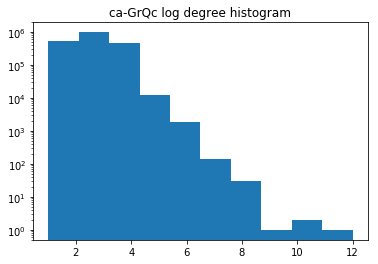

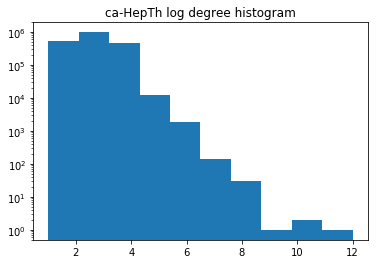

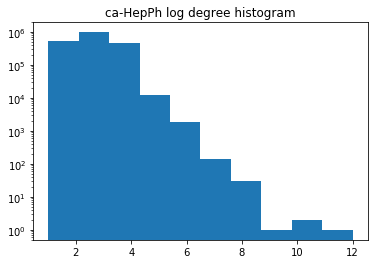

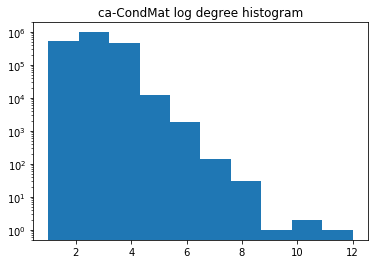

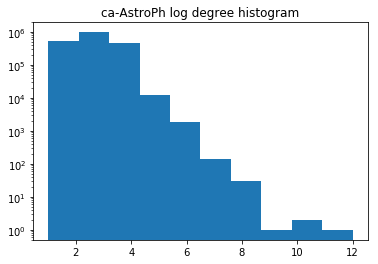

In [20]:
for G_file in part1_datasets:
    custom_k = 1
    if G_file in datasets:
        custom_k = None
    G_id, edges, k = read_graph_data(G_file, subsample=None, custom_k=custom_k)
    plt.hist(get_degrees(G))
    plt.yscale('log')
    plt.title(G_id + ' log degree histogram')
    plt.show()

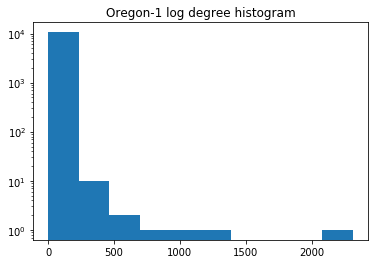

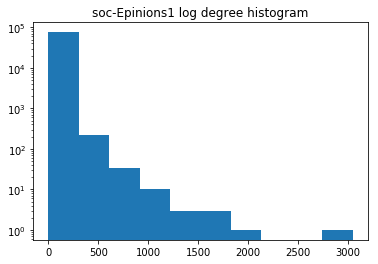

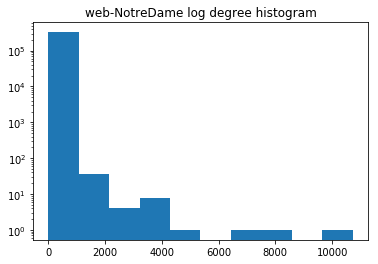

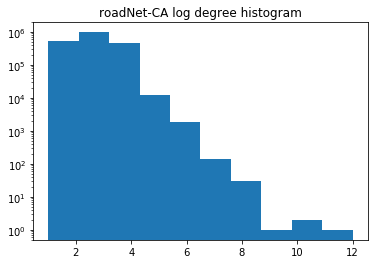

In [21]:
for G_file in datasets:
    G_id, edges, k = read_graph_data(G_file, subsample=None)
    G = get_networkx_graph(G_id, edges)
    plt.hist(get_degrees(G))
    plt.yscale('log')
    plt.title(G_id + ' log degree histogram')
    plt.show()

## DEMO 1 
## Run clustering functions and write an output file

$\textbf{NOTE}$ Please run the code below if a "results" folder is not present in the notebook path.

In [22]:
try:
    import os
    os.mkdir('results')
except:
    pass

Running the run_save_res_spectral:

 - graphs: give as arguments, strings of file names that you want to write the results for
 - laplacian_type = $"normalized"$, $"unnormalized"$ or $"shi\_malik"$
 
Output: The function will compute all the output files in the format of the competition, and a summary of the clustering's quality will be printed.

$\textbf{NOTE}$ You need to put the files elsewhere, if you want some output files results saved, or else they will be overwritten by the next run!!

In [27]:
def run_save_res_spectral(graphs=['ca-GrQc.txt','Oregon-1.txt'],laplacian_type='unnormalized', custom_ks=[None, None]):
    for i, graph in enumerate(graphs):
        if custom_ks[i]:
            G_id, edges, k = read_graph_data(graph, custom_k=custom_ks[i])
        else:
            G_id, edges, k = read_graph_data(graph)
        G = get_networkx_graph(G_id, edges)
        cluster = spectral_clustering_balanced(G,k,laplacian_type=laplacian_type)
        results = objective_function(G,cluster)
        print("For cluster " + graph + " the objective function is: " + str(results[0]) 
                          + " with " + str(results[1]) + " number of cuts and " + str(results[2]) + 
                          " min dimension of a cluster"  )
        write_results(G_id,G,cluster,k)

In [28]:
run_save_res_spectral(laplacian_type='unnormalized')

For cluster ca-GrQc.txt the objective function is: 0.08333333333333333 with 1 number of cuts and 12 min dimension of a cluster
For cluster Oregon-1.txt the objective function is: 15.5 with 93 number of cuts and 6 min dimension of a cluster


In [29]:
def run_save_res_bridge(graphs=['ca-GrQc.txt'], custom_ks=[None]):
    for i, graph in enumerate(graphs):
        if custom_ks[i]:
            G_id, edges, k = read_graph_data(graph, custom_k=custom_ks[i])
        else:
            G_id, edges, k = read_graph_data(graph)
        G = get_networkx_graph(G_id, edges)
        cluster = bridge_cut_clustering(G,k)
        results = objective_function(G,cluster)
        print("For cluster " + graph + " the objective function is: " + str(results[0]) 
                          + " with " + str(results[1]) + " number of cuts and " + str(results[2]) + 
                          " min dimension of a cluster"  )
        write_results(G_id,G,cluster,k)

In [30]:
run_save_res_bridge()


For cluster ca-GrQc.txt the objective function is: 0.0625 with 1 number of cuts and 16 min dimension of a cluster


In [31]:
run_save_res_spectral(['ca-GrQc.txt'], laplacian_type='unnormalized', custom_ks=[2])
run_save_res_spectral(['ca-GrQc.txt'], laplacian_type='normalized', custom_ks=[2])
run_save_res_spectral(['ca-GrQc.txt'], laplacian_type='shi_malik', custom_ks=[2])
run_save_res_bridge(['ca-GrQc.txt'], custom_ks=[2])

For cluster ca-GrQc.txt the objective function is: 0.08333333333333333 with 1 number of cuts and 12 min dimension of a cluster
For cluster ca-GrQc.txt the objective function is: 0.52 with 26 number of cuts and 50 min dimension of a cluster


/home/alex/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


For cluster ca-GrQc.txt the objective function is: 0.075 with 3 number of cuts and 40 min dimension of a cluster



For cluster ca-GrQc.txt the objective function is: 0.0625 with 1 number of cuts and 16 min dimension of a cluster


## DEMO 2

clustering_analysis:
 - clustering_vals: List of lists that has the number of clusters for which one wants to compute the objective function
 - graphs_required: the graphs on which the analysis is needed
 - required_points: Print and show on the graph the points needed (i.e., used to get the points required by the assignment)
 
Finally, clustering_analysis runs "plot_results", the objective function as a function of the number of clusters. Useful function to see how consistent does a spectral algorithm return better/worse values. In our case, you should usually see better results on spectral clustering.

$\textbf{NOTE}$ If you add big numbers on clustering values and bigger graphs than the one shown, expect a very long time to compute (hours) <- since it's computing spectral clusterings with different Laplacian matrices for each k value required for each of the graphs.

/home/alex/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)



Results on the required points for graph ca-GrQc.txt
Shi_malik: 0.075
unnnormalized 0.08333333333333333
normalized 0.52
Bridge cuts 0.0625


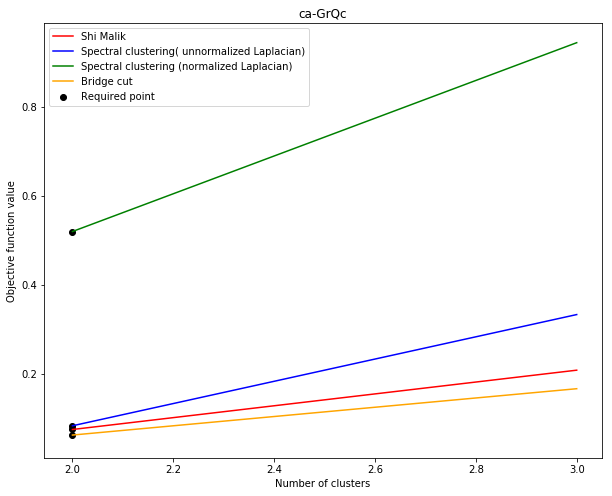

Results on the required points for graph Oregon-1.txt
Shi_malik: 0.5506329113924051
unnnormalized 6.3
normalized 2.9255014326647566
Bridge cuts 0.3333333333333333


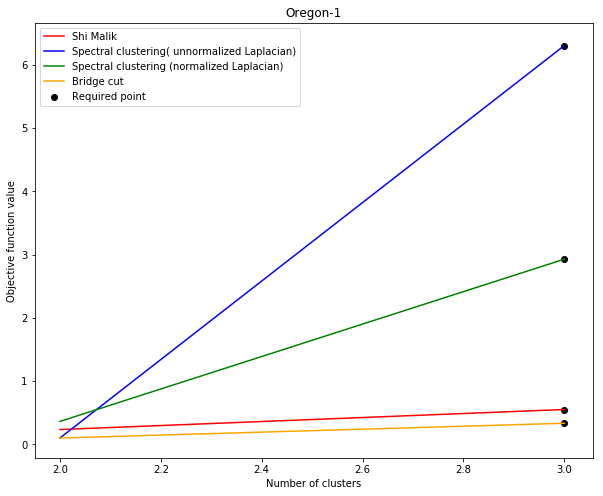

In [32]:
clustering_analysis(clustering_vals=[[2,3],[2,3]],
                    graphs_required=['ca-GrQc.txt','Oregon-1.txt'],
                    required_points=[2,3])